In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os 
import numpy as np 
import keras 
import re 
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 

import tensorflow as tf 
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.models import Model


In [ ]:
# plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.figsize"] = (15,15)



Adapted and modified from https://www.youtube.com/watch?v=M5NygAGT5AI&t=1493s

Load Data
---
---

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('drive/MyDrive/COMP90055/code/all_data')


In [ ]:
bad_coastal = [4,5,31,39,68,69,74,75,76,89,90,102,121,206,216,217,220,221,248,249,309,310,313,315,316,336,337,361,431,443,488]
weird = [33,35,52,55,276,333,334,335,444]

exclude = [str(num) + ".png" for num in bad_coastal + weird]

In [ ]:

## Load masks
mask_directory = '224_masks_filtered'
image_directory = '224_images_filtered'

mask_filenames = [filename for filename in os.listdir(mask_directory) if filename.endswith(('.png', '.jpeg', '.jpg')) and filename not in exclude]



filenames = mask_filenames


masks = []

for filename in filenames:

    mask = cv2.imread(os.path.join(mask_directory, filename), cv2.IMREAD_GRAYSCALE)
    # plt.imshow(mask)
    mask[mask == 2] = 0 ## This removes the cloud mask 
    mask = cv2.resize(mask, (112,112), cv2.INTER_NEAREST)
    masks.append(mask)

masks_array = np.array(masks)


images = []


for filename in filenames:
  
    image = cv2.imread(os.path.join(image_directory, filename))
    images.append(image)


images_array = np.array(images)
display_images = images_array.copy() ## Used to show feature extractors
images_array = preprocess_input(images_array)
images_array, masks_array, display_images = sklearn.utils.shuffle(images_array, masks_array, display_images, random_state = 90055)


print(images_array.shape)
print(masks_array.shape)


(484, 224, 224, 3)
(484, 112, 112)


In [ ]:
train_index = int(images_array.shape[0] * 0.7)
val_index = int(images_array.shape[0] * 0.2)

masks_array

x_train = images_array[:train_index]
x_val = images_array[train_index:train_index + val_index]
x_test = images_array[train_index + val_index:]

y_train = masks_array[:train_index]
y_val = masks_array[train_index:train_index + val_index]
y_test = masks_array[train_index + val_index:]

x_fin_train = images_array[:train_index + val_index]
y_fin_train = masks_array[:train_index + val_index]

In [ ]:
res_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


res_model.trainable = False

res_model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
mod1 = Model(inputs = res_model.inputs, outputs = res_model.get_layer('conv1_conv').output)

mod1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)       0         
                                                                 
 conv1_conv (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
Total params: 9,472
Trainable params: 0
Non-trainable params: 9,472
_________________________________________________________________


In [ ]:
features = mod1.predict(x_train)

11/11 [==============================] - 7s 16ms/step


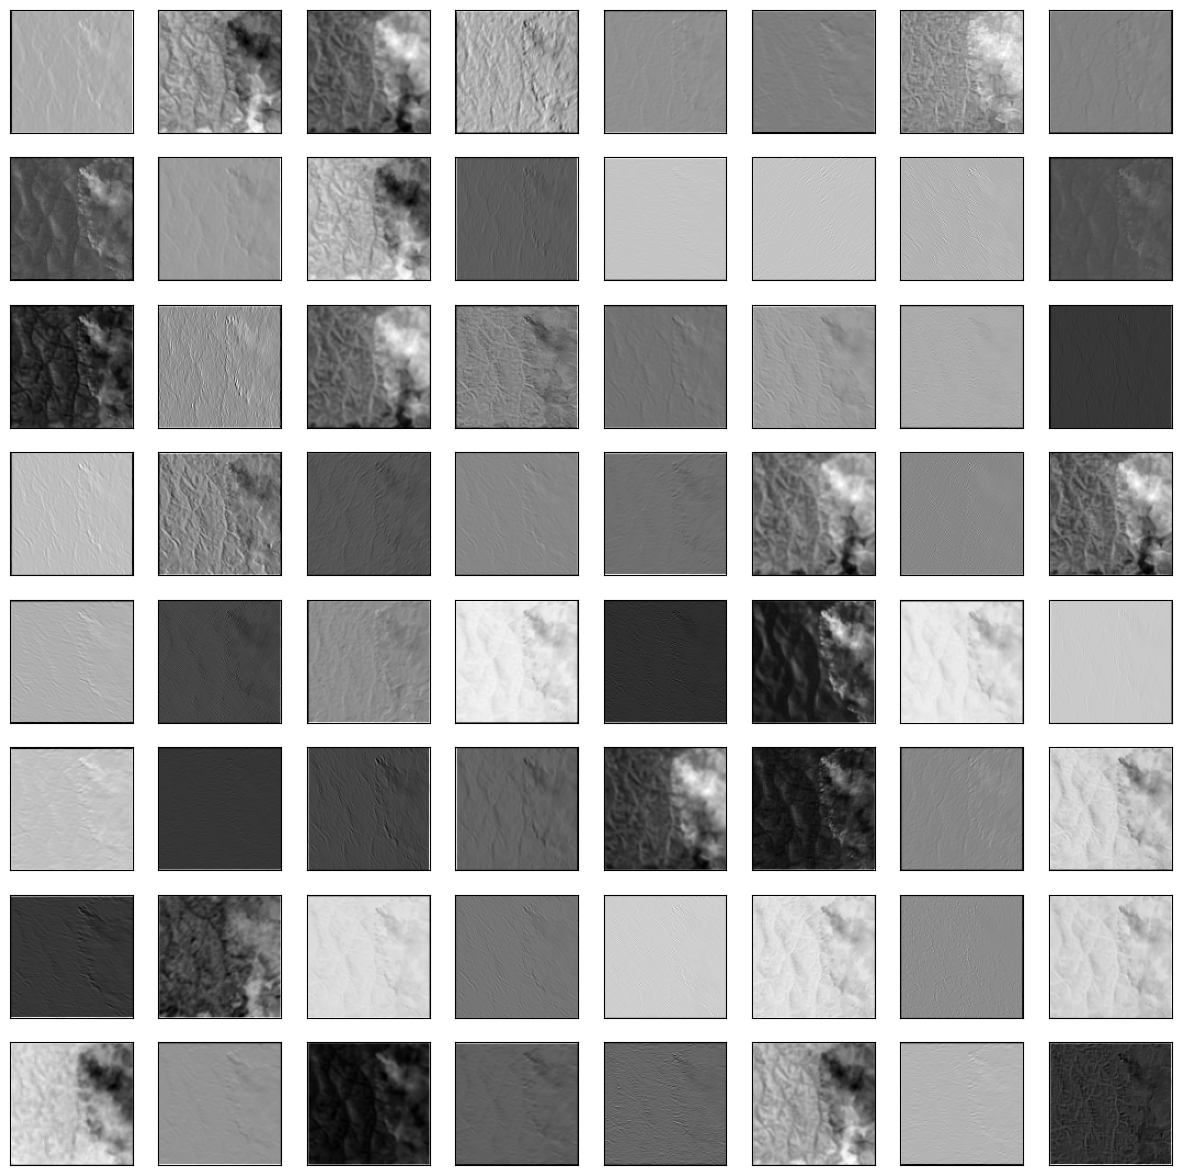

In [ ]:
## Visualise the features

square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[1,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()


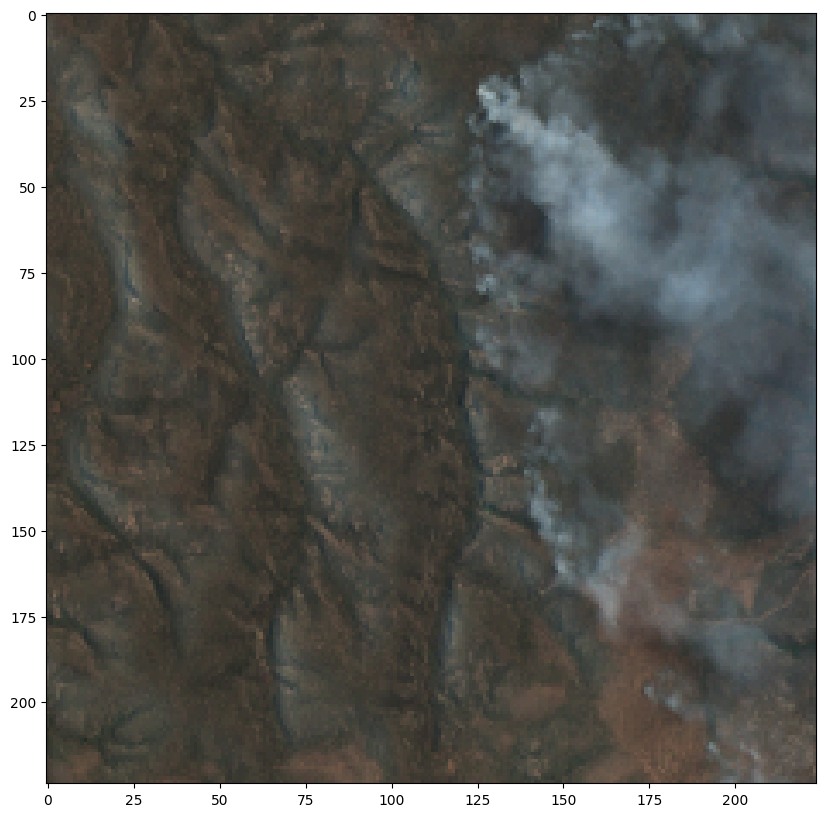

In [ ]:
plt.imshow(display_images[1]*3.5/255)

In [ ]:

square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features2[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

[0 1]
0    4189745
1      50127
Name: Label, dtype: int64


In [ ]:

X=features
X = X.reshape(-1, X.shape[3])  

Y = y_train.reshape(-1)
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())
X_for_training = dataset.drop(labels = ['Label'], axis=1)
X_for_training = X_for_training.values  
Y_for_training = dataset['Label']
Y_for_training = Y_for_training.values 


XG Boosted Tree
---

In [ ]:
import xgboost as xgb
# model = xgb.XGBClassifier(use_rmm = True, verbosity = 2)
model = xgb.XGBClassifier()
model.fit(X_for_training, Y_for_training) 


In [ ]:
import pickle

In [ ]:
filename = 'model_RES50V2_XG.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
filename = 'model_RES50V2_XG.sav'
loaded_model = pickle.load(open(filename, 'rb'))



In [ ]:
## Checking the results on our test dataset
features = mod1.predict(x_test)

X=features
X = X.reshape(-1, features.shape[3])

Y = y_test.reshape(-1)

dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

X_for_test = dataset.drop(labels = ['Label'], axis=1)
X_for_test = X_for_test.values  #Convert to array
Y_for_test = dataset['Label']
Y_for_test = Y_for_test.values  #Convert to array


2/2 [==============================] - 0s 7ms/step
[0 1]
0    620408
1      6792
Name: Label, dtype: int64


NameError: ignored

In [ ]:
from sklearn import metrics

precision = metrics.precision_score(preds, y_test.reshape(-1))
recall = metrics.recall_score(preds, y_test.reshape(-1))
IoU = metrics.jaccard_score(preds, y_test.reshape(-1))

print("Precison: ", precision)
print("Recall ", recall)
print("IoU", IoU)

Precison:  0.03702764392594471
Recall  0.4907563025210084
IoU 0.0356575894492612


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


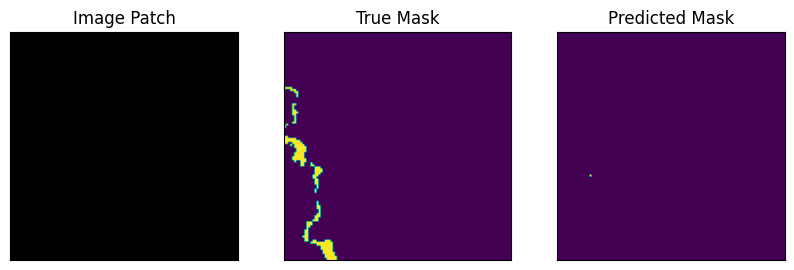

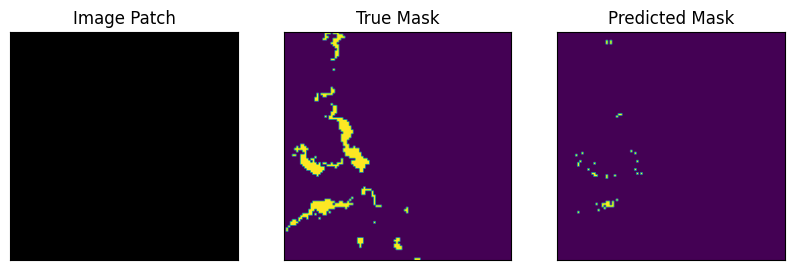

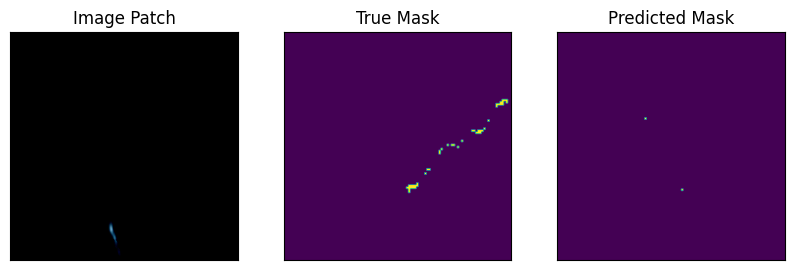

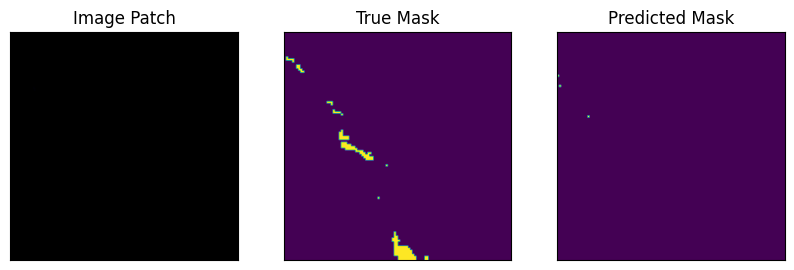

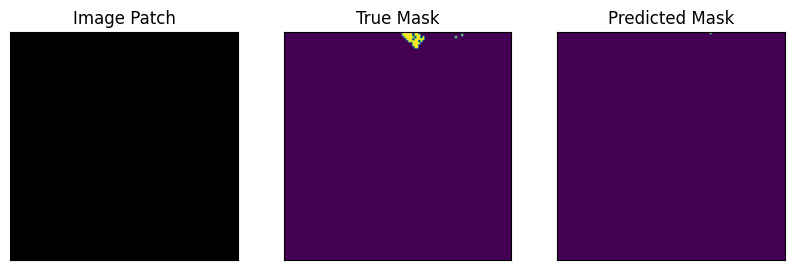

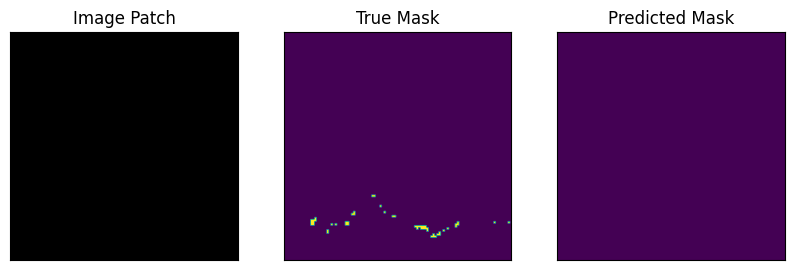

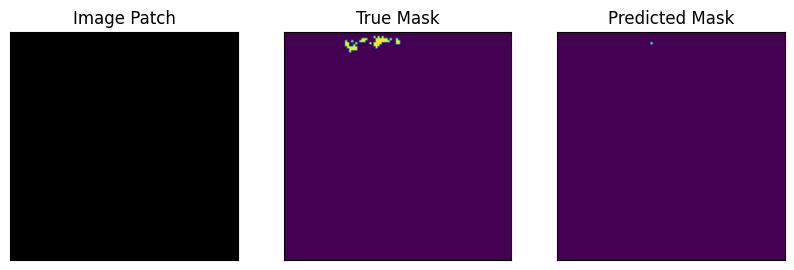

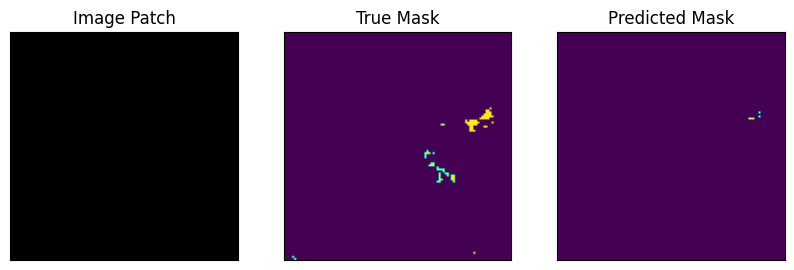

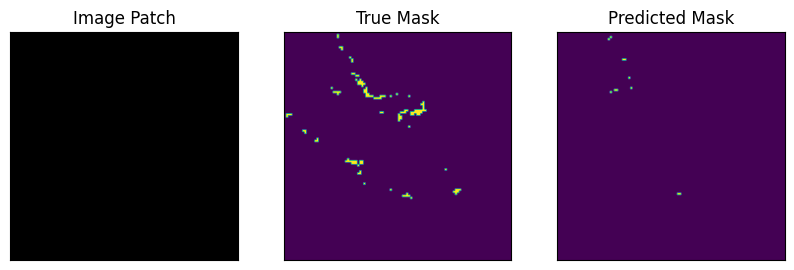

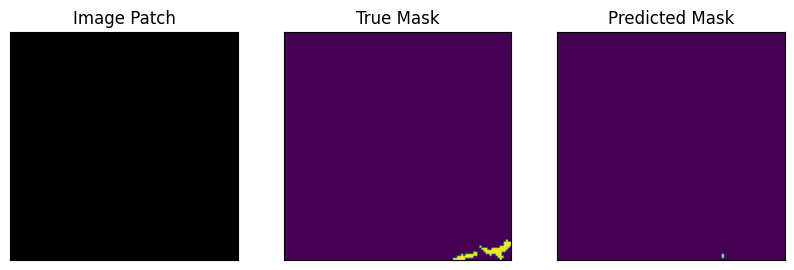

In [ ]:
from sklearn import metrics

precision = metrics.precision_score(preds, y_test.reshape(-1))
recall = metrics.recall_score(preds, y_test.reshape(-1))
IoU = metrics.jaccard_score(preds, y_test.reshape(-1))

print("Precison: ", precision)
print("Recall ", recall)
print("IoU", IoU)

for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]



  test_img = np.expand_dims(true_img, axis=0)
  # print(test_img.shape)

  X_test_feature = mod1.predict(test_img)
  X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])
  prediction = loaded_model.predict(X_test_feature)
  prediction_image = prediction.reshape(mask.shape)


    

  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img)
  ax.set_title('Image Patch')
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)



Hyper Parameter Tuning

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Define the objective function to be optimized
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'eval_metric': 'aucpr',
        'objective': 'binary:logistic',

    }

    # Create a cross-validation object using XGBoost
    clf = xgb.XGBClassifier(**params, tree_method = 'gpu_hist')

    # Perform cross-validation and return the mean ROC AUC score
    scores = cross_val_score(clf, X_for_training, Y_for_training, cv=5, scoring='roc_auc')
    return scores.mean()

# Define the parameter bounds for Bayesian optimization
param_bounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 1000),
    'gamma': (0, 5),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# Initialize the Bayesian optimization object
opt = BayesianOptimization(xgb_cv, param_bounds)

# Start the optimization process
opt.maximize(init_points=5, n_iter=10)

# Print the best hyperparameters found
print(opt.max)


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9024    | 0.7571    | 4.554     | 0.2871    | 3.39      | 5.242     | 402.3     | 0.838     |
| 2         | 0.8933    | 0.6642    | 1.893     | 0.2073    | 7.298     | 5.433     | 982.9     | 0.6242    |
| 3         | 0.898     | 0.7831    | 3.553     | 0.1693    | 9.405     | 6.838     | 888.4     | 0.5489    |
| 4         | 0.9064    | 0.533     | 4.061     | 0.057     | 5.584     | 7.381     | 646.5     | 0.8553    |
| 5         | 0.9087    | 0.5735    | 4.665     | 0.1098    | 8.344     | 4.867     | 240.9     | 0.6657    |
| 6         | 0.9064    | 0.9405    | 3.906     | 0.1918    | 6.995     | 7.402     | 646.6     | 0.7631    |
| 7         | 0.804     | 0.5       | 0.0       | 0.01      | 3.0       | 10.0      | 100.0     | 1.0       |
| 8       

In [ ]:
params = opt.max['params']
params['objective'] = 'binary:logistic'
params

{'colsample_bytree': 0.5735263960839121,
 'gamma': 4.664991262027318,
 'learning_rate': 0.10981163666606919,
 'max_depth': 8.344076892556927,
 'min_child_weight': 4.866600338537674,
 'n_estimators': 240.89092052411948,
 'subsample': 0.6657005718617575,
 'objective': 'binary:logistic'}

In [ ]:
import xgboost as xgb


params = {
    'colsample_bytree': 0.5735263960839121,
    'gamma': 4.664991262027318,
    'learning_rate': 0.10981163666606919,
    'max_depth': int(8.344076892556927),
    'min_child_weight': 4.866600338537674,
    'n_estimators': int(240.89092052411948),
    'subsample': 0.6657005718617575
}



honed_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='gpu_hist',
    verbosity=2,
    **params
)


features = mod1.predict(x_fin_train)

X=features
X = X.reshape(-1, features.shape[3])

#Reshape Y to match X
Y = y_fin_train.reshape(-1)

dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

X_for_fin = dataset.drop(labels = ['Label'], axis=1)
X_for_fin = X_for_fin.values  #Convert to array
# X_for_training = X_for_training.astype(np.int16)
Y_for_fin = dataset['Label']
Y_for_fin = Y_for_fin.values  #Convert to array
# Y_for_training = Y_for_training.astype(np.int16)

# features = mod1.predict(x_test)


# preds = honed.predict(X_for_fin)

honed_xgb.fit(X_for_fin, Y_for_fin)

14/14 [==============================] - 0s 8ms/step
[0 1]
0    5379438
1      64658
Name: Label, dtype: int64


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5735263960839121, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.664991262027318, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10981163666606919, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=4.866600338537674, missing=nan,
              monotone_constraints=None, n_estimators=240, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

NameError: ignored

In [ ]:
## Checking the results on our test dataset
features = mod1.predict(x_test)

X=features
X = X.reshape(-1, features.shape[3])

#Reshape Y to match X
Y = y_test.reshape(-1)

dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

X_for_test = dataset.drop(labels = ['Label'], axis=1)
X_for_test = X_for_test.values  #Convert to array
# X_for_training = X_for_training.astype(np.int16)
Y_for_test = dataset['Label']
Y_for_test = Y_for_test.values  #Convert to array
# Y_for_training = Y_for_training.astype(np.int16)

# features = mod1.predict(x_test)


preds = honed_xgb.predict(X_for_test)

from sklearn import metrics
accuracy = metrics.accuracy_score(preds, y_test.reshape(-1))

print("Accuracy: ", accuracy)
# print("Precison: ", precision)


2/2 [==============================] - 0s 7ms/step
[0 1]
0    620408
1      6792
Name: Label, dtype: int64
Accuracy:  0.9890385841836735


2/2 [==============================] - 0s 7ms/step
[0 1]
0    620408
1      6792
Name: Label, dtype: int64
Precison:  0.0449057714958775
Recall  0.4401154401154401
IoU 0.04247910863509749
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


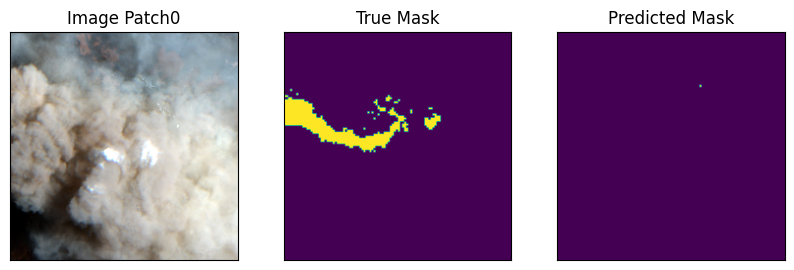

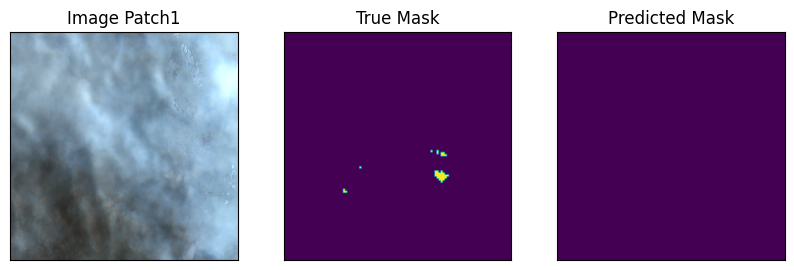

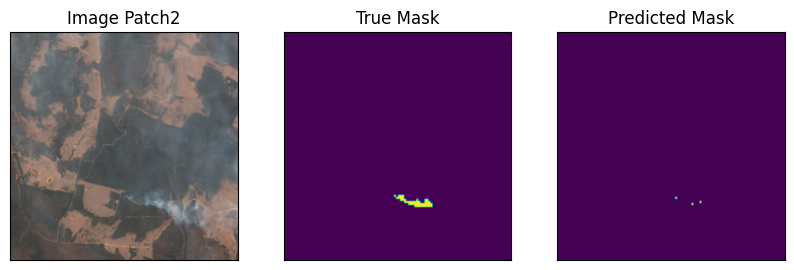

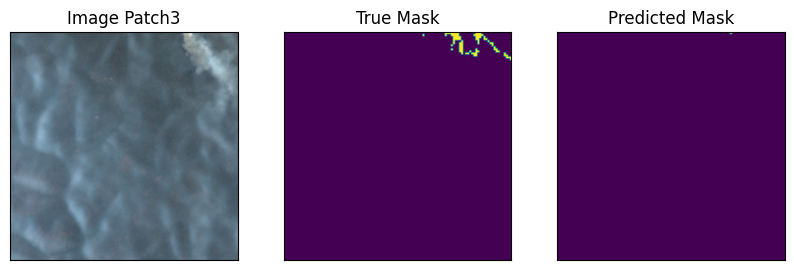

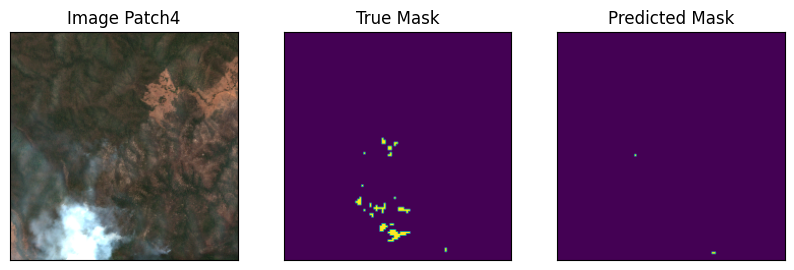

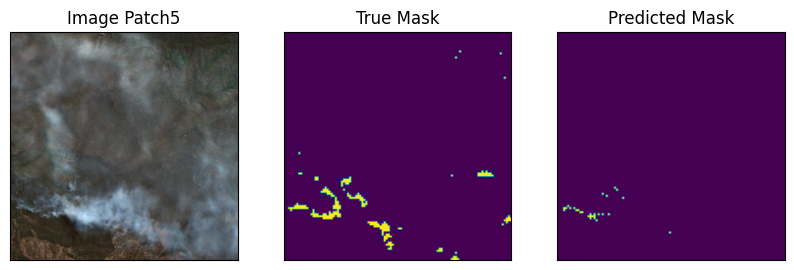

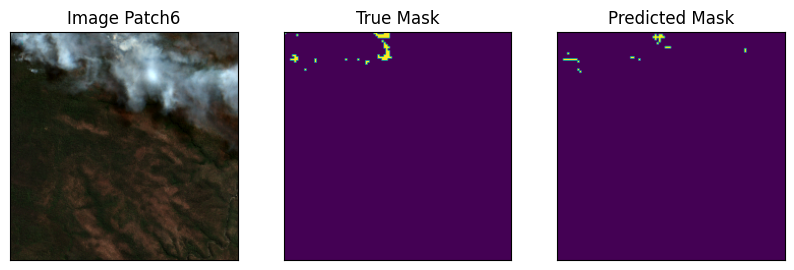

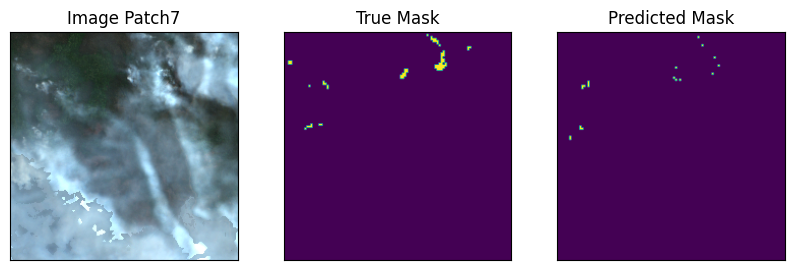

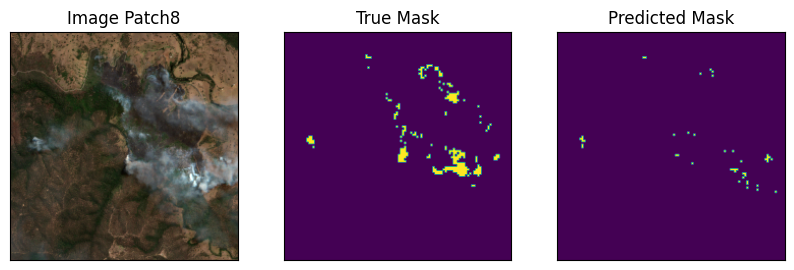

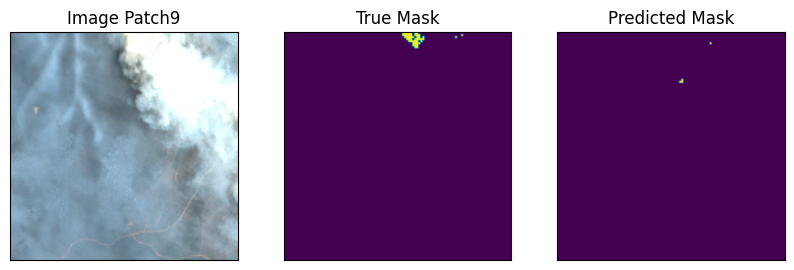

In [ ]:
## Checking the results on our test dataset
features = mod1.predict(x_test)

X=features
X = X.reshape(-1, features.shape[3])

#Reshape Y to match X
Y = y_test.reshape(-1)

dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

X_for_test = dataset.drop(labels = ['Label'], axis=1)
X_for_test = X_for_test.values  #Convert to array
# X_for_training = X_for_training.astype(np.int16)
Y_for_test = dataset['Label']
Y_for_test = Y_for_test.values  #Convert to array
# Y_for_training = Y_for_training.astype(np.int16)

# features = mod1.predict(x_test)


preds = honed_xgb.predict(X_for_test)

from sklearn import metrics

precision = metrics.precision_score(preds, y_test.reshape(-1))
recall = metrics.recall_score(preds, y_test.reshape(-1))
IoU = metrics.jaccard_score(preds, y_test.reshape(-1))

print("Precison: ", precision)
print("Recall ", recall)
print("IoU", IoU)

for i in range(len(x_test[0:10])):

  true_img = x_test[i]
  mask = y_test[i]



  test_img = np.expand_dims(true_img, axis=0)
  # print(test_img.shape)

  X_test_feature = mod1.predict(test_img)
  X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])
  prediction = honed_xgb.predict(X_test_feature)
  prediction_image = prediction.reshape(mask.shape)

  true_img = display_images[train_index + val_index + i]


    

  fig, (ax, m_ax, p_ax) = plt.subplots(ncols = 3)
  ax.imshow(true_img*3.5/255)
  ax.set_title('Image Patch' + str(i))
  ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  ax.tick_params(axis = 'y' , left = False, labelleft = False)


  m_ax.imshow(mask)
  m_ax.set_title('True Mask')
  m_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  m_ax.tick_params(axis = 'y' , left = False, labelleft = False)

  p_ax.imshow(prediction_image)
  p_ax.set_title('Predicted Mask')
  p_ax.tick_params(axis = 'x' , bottom = False, labelbottom = False)
  p_ax.tick_params(axis = 'y' , left = False, labelleft = False)
